In [1]:
import os
from typing import Tuple, List
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# constants
DATA_DIR: str = "data/tumor_mri"
TRAIN_DIR: str = os.path.join(DATA_DIR, "Training")
TEST_DIR: str = os.path.join(DATA_DIR, "Testing")
IMG_SIZE: Tuple[int, int] = (150, 150)
BATCH_SIZE: int = 32
VALID_SPLIT: float = 0.2
EPOCHS: int = 20
CLASS_NAMES: List[str] = ["glioma", "meningioma", "notumor", "pituitary"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES: int = len(CLASS_NAMES)


In [9]:
def limit_dataset(dataset: datasets.ImageFolder, max_images: int) -> datasets.ImageFolder:
    class_counts = {cls: 0 for cls in dataset.classes}
    indices = []
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        if class_counts[class_name] < max_images:
            indices.append(idx)
            class_counts[class_name] += 1
    dataset.samples = [dataset.samples[i] for i in indices]
    dataset.targets = [dataset.targets[i] for i in indices]
    return dataset


def create_data_loaders(train_dir: str,
                        test_dir: str,
                        img_size: Tuple[int, int],
                        batch_size: int,
                        valid_split: float,
                        max_images_per_class: int = None
                        ) -> Tuple[DataLoader, DataLoader, DataLoader]:
    tfms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    full_train = datasets.ImageFolder(train_dir, transform=tfms)
    test_ds = datasets.ImageFolder(test_dir, transform=tfms)

    if max_images_per_class is not None:
        full_train = limit_dataset(full_train, max_images_per_class)
        test_ds = limit_dataset(test_ds, max_images_per_class)

    val_size = int(len(full_train) * valid_split)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size),
        DataLoader(test_ds, batch_size=batch_size)
    )


train_loader, val_loader, test_loader = create_data_loaders(
    TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE, VALID_SPLIT, max_images_per_class=100
)

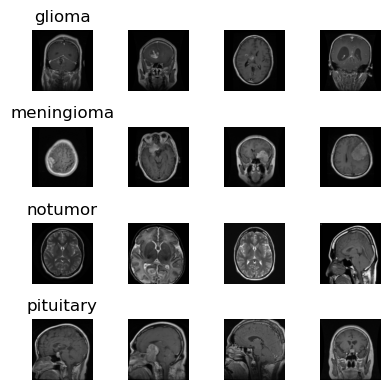

In [10]:
def get_class_samples(loader: DataLoader,
                      class_names: List[str],
                      samples_per_class: int
                      ) -> dict[str, List[torch.Tensor]]:
    samples = {c: [] for c in class_names}
    for imgs, labels in loader:
        for img, lbl in zip(imgs, labels):
            name = class_names[lbl]
            if len(samples[name]) < samples_per_class:
                samples[name].append(img)
        if all(len(v) >= samples_per_class for v in samples.values()):
            break
    return samples

def show_grid(samples: dict[str, List[torch.Tensor]], cols: int = 4) -> None:
    graphic_size = 1
    rows = len(samples)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*graphic_size, rows*graphic_size))
    for i, (cls, imgs) in enumerate(samples.items()):
        for j in range(cols):
            ax = axes[i, j]
            ax.imshow(imgs[j].permute(1,2,0))
            ax.axis("off")
            if j == 0:
                ax.set_title(cls)
    plt.tight_layout()
    plt.show()

train_samples = get_class_samples(train_loader, CLASS_NAMES, 4)
show_grid(train_samples)

# test_samples = get_class_samples(test_loader, CLASS_NAMES, 4)
# show_grid(test_samples)


## Model

In [ ]:
class TumorCNN(nn.Module):
    def __init__(self, num_classes: int = NUM_CLASSES, img_size: Tuple[int, int] = IMG_SIZE):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size[0]//8) * (img_size[1]//8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.features(x))

model = TumorCNN(NUM_CLASSES).to(DEVICE)
print(model)


TumorCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=41472, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [ ]:
def train_one_epoch(model: nn.Module,
                    loader: DataLoader,
                    criterion: nn.Module,
                    optimizer: optim.Optimizer
                    ) -> Tuple[float, float]:
    model.train()
    total_loss, correct, count = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        preds = model(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (preds.argmax(1) == labels).sum().item()
        count += imgs.size(0)
    return total_loss/count, correct/count


def validate(model: nn.Module,
             loader: DataLoader,
             criterion: nn.Module
             ) -> Tuple[float, float]:
    model.eval()
    total_loss, correct, count = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            preds = model(imgs)
            loss = criterion(preds, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            count += imgs.size(0)
    return total_loss/count, correct/count


def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                epochs: int
                ) -> dict[str, List[float]]:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": []}
    for _ in range(epochs):
        tl, ta = train_one_epoch(model, train_loader, criterion, optimizer)
        vl, va = validate(model, val_loader, criterion)
        history["train_loss"].append(tl)
        history["train_acc"].append(ta)
        history["val_loss"].append(vl)
        history["val_acc"].append(va)
    return history


history = train_model(model, train_loader, val_loader, EPOCHS)

In [ ]:
def plot_history(history: dict[str, List[float]]) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(history["train_loss"], label="train")
    axes[0].plot(history["val_loss"], label="val")
    axes[0].set_title("Loss"); axes[0].legend()
    axes[1].plot(history["train_acc"], label="train")
    axes[1].plot(history["val_acc"], label="val")
    axes[1].set_title("Accuracy"); axes[1].legend()
    plt.show()

def test_evaluate(model: nn.Module,
                  loader: DataLoader
                  ) -> None:
    loss, acc = validate(model, loader, nn.CrossEntropyLoss())
    print(f"Test Loss: {loss:.4f}\nTest Accuracy: {acc:.4f}")

plot_history(history)
test_evaluate(model, test_loader)
